# Brazilian Wind Farm Layout Optimization

In [1]:
import rasterio
from shapely.geometry import mapping
import os
import rasterio.mask
from rasterio.enums import Resampling
from rasterio.warp import reproject, Resampling
from rasterio import features
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from osgeo import gdal
import numpy as np
from pyproj import Transformer
from scipy.ndimage import uniform_filter
import elevation
import tempfile
import seaborn as sns
import osmnx as ox
import pyrosm
from src.utils import DATA_DIR, KILOMETERS_OFFSHORE

/tmp/ipykernel_1742/3842516768.py:8: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-2xif_q30 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to 

In [2]:
plt.style.use('dark_background')

In [3]:
def plot_raster(raster):
    fig, ax = plt.subplots(figsize=(10, 10))

    if raster.shape[0] > 10000:
        img = raster[::100, ::100]

    elif raster.shape[0] > 1000:
        img = raster[::10, ::10]
    else:
        img = raster
    raster_masked = np.ma.masked_where(img == -9999, img)
    # normalize the data
    ax.imshow(raster_masked, cmap='gray')  # Apply a color map if desired
    plt.show()

## load data

In [8]:
def load_vector(fp):
    df = pd.read_csv(f'{DATA_DIR}/{fp}')
    df['geometry'] = gpd.GeoSeries.from_wkt(df['geometry'])
    return gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')


In [4]:
def load_raster(fp, area=None):
    """
    Loads raster data and crops it to the area of interest.
    """
    if fp.startswith('topography'):
        dataset = gdal.Open(f"{DATA_DIR}/{fp}")
        array = dataset.ReadAsArray()
        dataset = None
        with rasterio.open(f"{DATA_DIR}/{fp}") as src:
            transform = src.transform
            metadata = src.meta
            nodata = src.nodatavals[0]
        return {'array': array, 'transform': transform, 'metadata': metadata, 'nodata': nodata}
    else:
        geometry = [mapping(polygon) for polygon in area.geometry]
        with rasterio.open(f"{DATA_DIR}/{fp}") as src:
            out_image, out_transform = rasterio.mask.mask(src, geometry, crop=True)
            out_image = out_image[0].astype('float32')
            out_image[out_image < 0] = np.nan
            out_meta = src.meta
            nodata = src.nodatavals[0]
            out_meta['height'] = out_image.shape[0]
            out_meta['width'] = out_image.shape[1]
            return {'array': out_image, 'transform': out_transform, 'metadata': out_meta, 'nodata': nodata}

In [5]:
def buffer_geometry(geometry, distance):
    """
    Buffer a polygon by a given distance.
    """
    return geometry.to_crs('EPSG:3857').buffer(distance * 1000).to_crs('EPSG:4326')


def geometry_raster(geometry, raster):
    """
    Create a raster from a geometry.
    """
    return features.rasterize(
        [(geom, 1) for geom in geometry],
        out_shape=raster['array'].shape,
        transform=raster['transform'],
        fill=0,
        all_touched=True,
        dtype=np.uint8,
    )

In [14]:
def scale_and_crop_raster(source, target):
    dest_array = np.empty(target['array'].shape, dtype='float32')

    # Perform the reprojection
    reproject(
        source=source['array'],
        destination=dest_array,
        src_transform=source['transform'],
        src_crs=source['metadata']['crs'],
        dst_transform=target['transform'],
        dst_crs=target['metadata']['crs'],
        resampling=Resampling.nearest
    )

    return dest_array

def scale_data_helper(source, target):
    source['array'] = scale_and_crop_raster(source, target)
    source['transform'] = target['transform']
    return source

    

def scale_data(data, scale='small'):
    if scale == 'large':
        data['power_density'] = scale_data_helper(data['power_density'], data['topography'])
        data['wind_speed'] = scale_data_helper(data['wind_speed'], data['topography'])
        data['population'] = scale_data_helper(data['population'], data['topography'])
    if scale == 'mid':
        data['population'] = scale_data_helper(data['population'], data['wind_speed'])
        data['topography'] = scale_data_helper(data['topography'], data['wind_speed'])
        data['slope'] = scale_data_helper(data['slope'], data['wind_speed'])
        data['roughness'] = scale_data_helper(data['roughness'], data['wind_speed'])
    if scale == 'small':
        data['slope'] = scale_data_helper(data['slope'], data['population'])
        data['topography'] = scale_data_helper(data['topography'], data['population'])
        data['roughness'] = scale_data_helper(data['roughness'], data['population'])
        data['power_density'] = scale_data_helper(data['power_density'], data['population'])
        data['wind_speed'] = scale_data_helper(data['wind_speed'], data['population'])
    return data 

In [15]:
brazil = ox.geocode_to_gdf('Brazil').to_crs(epsg=3857).to_crs(epsg=4326).geometry
brazil_and_offshore = brazil.to_crs(epsg=3857).buffer(100 * 1000).to_crs(epsg=4326)
offshore = brazil_and_offshore.difference(brazil)

In [16]:
fps = {'power_density': 'meterology/gwa3_250_powerdensity_100m.tif', 'wind_speed': 'meterology/gwa3_250_windspeed_100m.tif',
        'population': 'demography/bra_pd_2020_1km.tif', 'topography': 'topography/brazil_dem.tif',
        'slope': 'topography/slope_gdal.tif', 'roughness': 'topography/roughness_gdal.tif'}


data = scale_data({k: load_raster(v, brazil) for k, v in fps.items()}, 'small') if 'data' not in locals() else eval('data')

In [19]:
brazil_mask = geometry_raster(brazil, data['topography'])
offshore_mask = geometry_raster(offshore, data['topography'])
brazil_and_offshore_mask = geometry_raster(brazil_and_offshore, data['topography'])


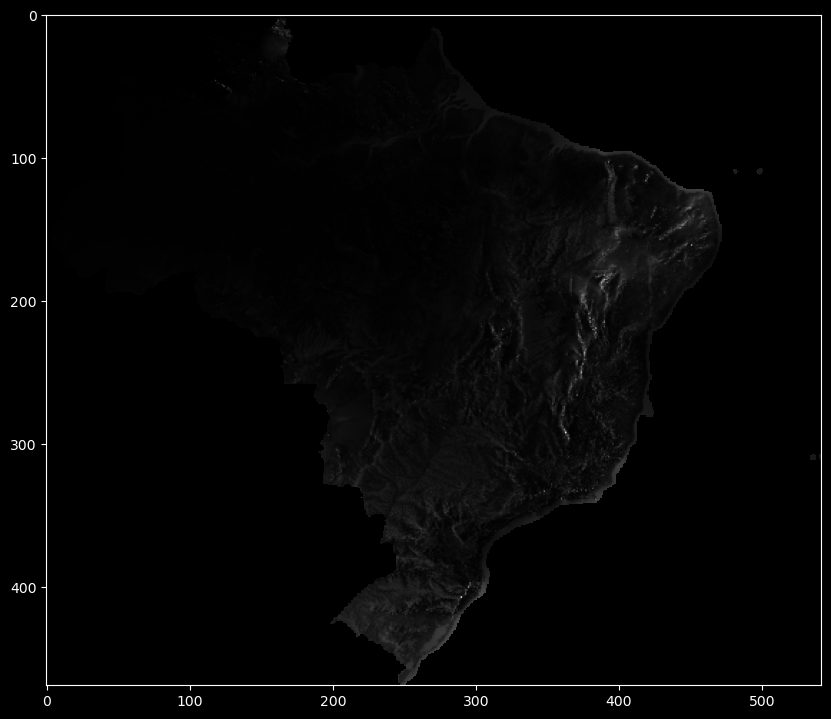

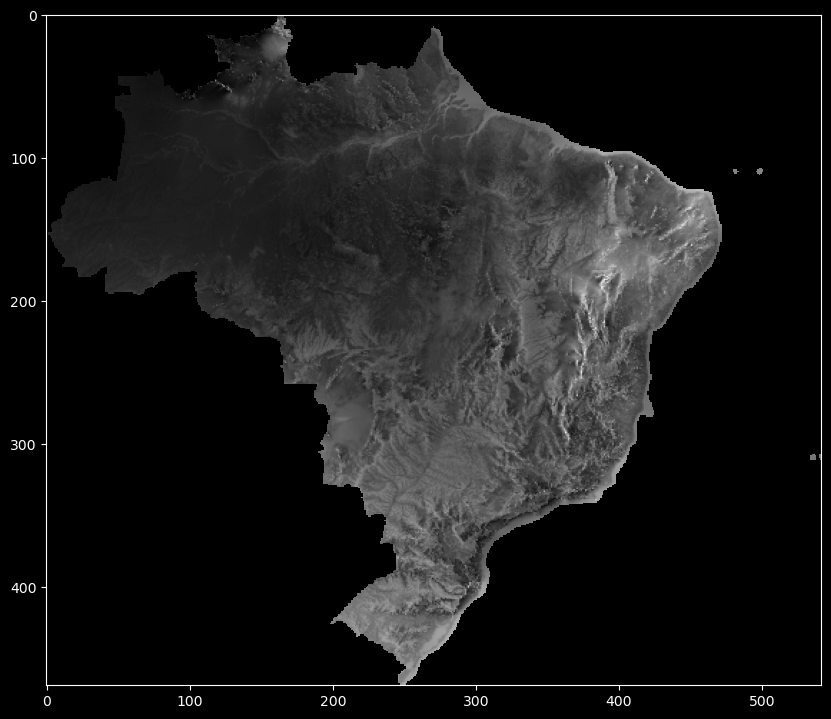

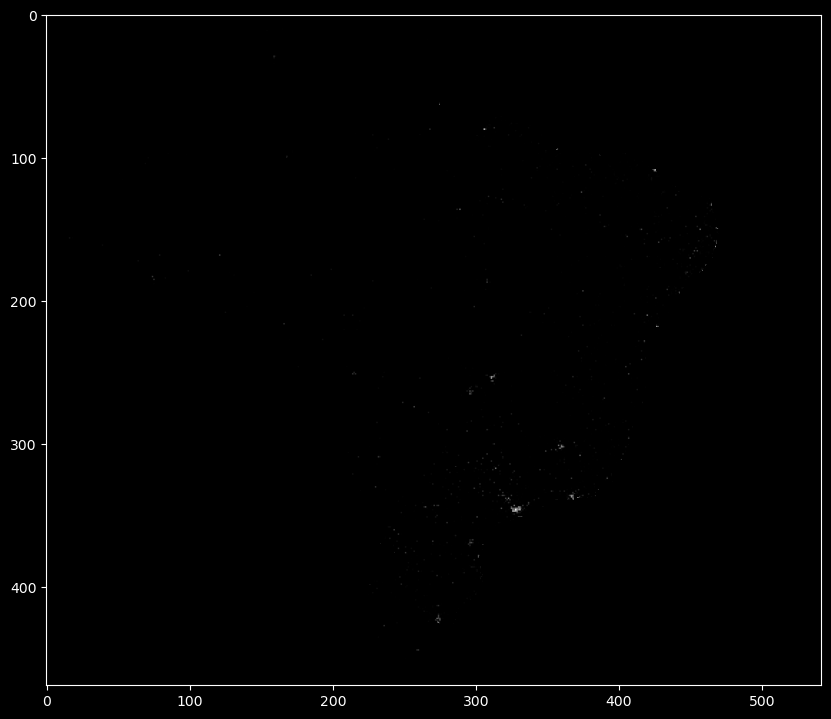

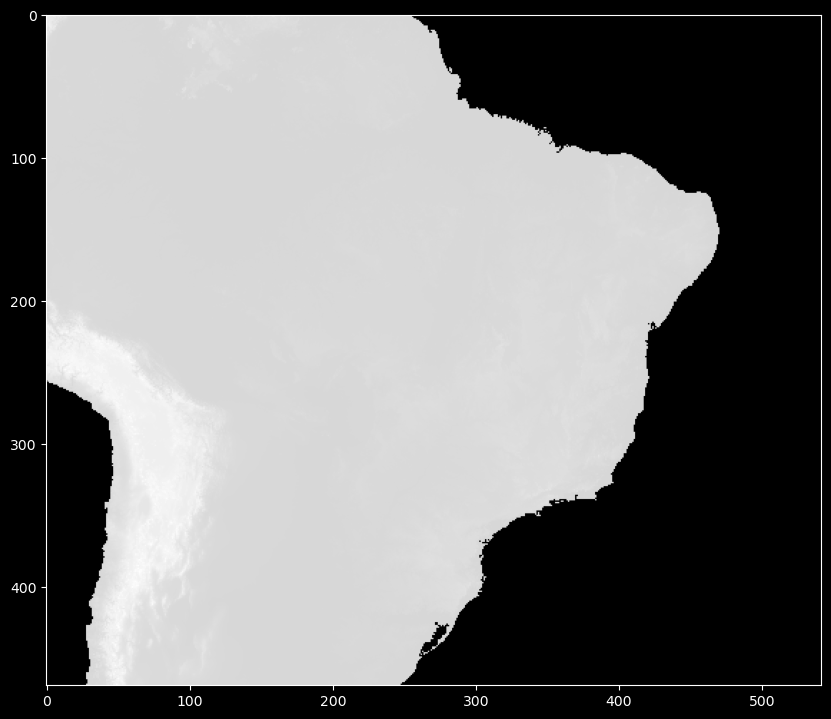

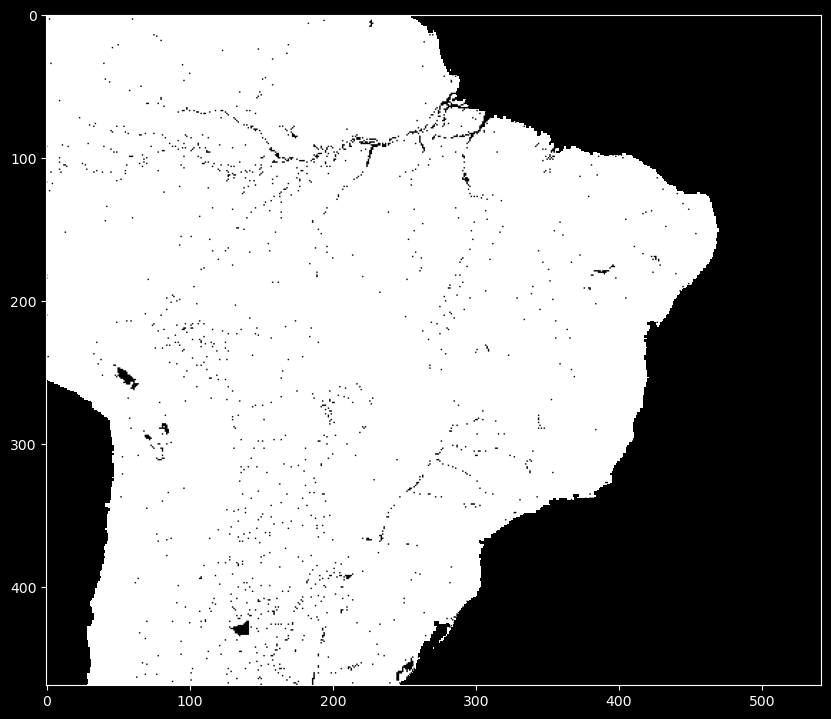

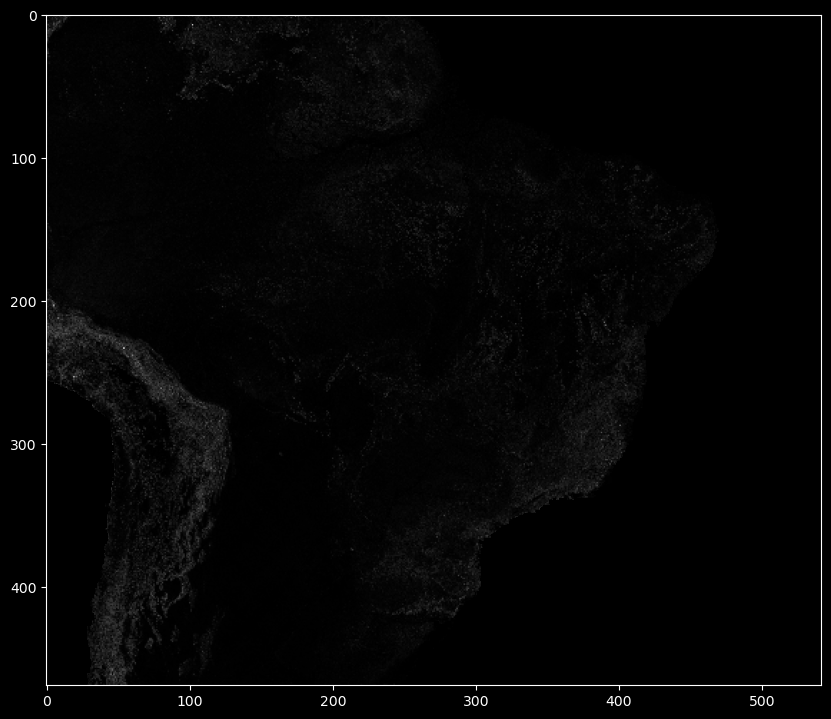

[None, None, None, None, None, None]

In [19]:
list(map(lambda x: plot_raster(x['array']), list(data.values())))

### vector data

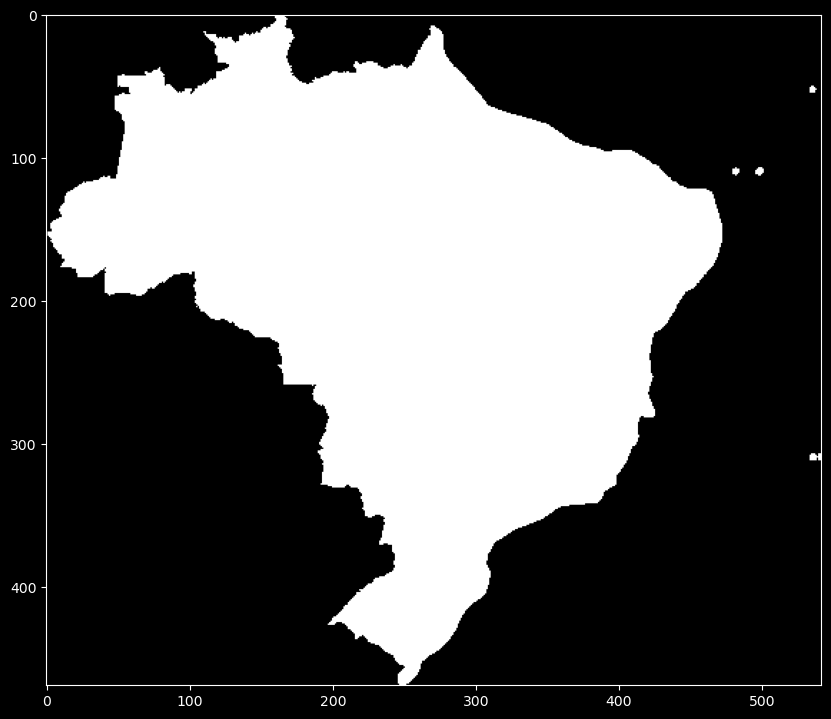

In [23]:
plot_raster(brazil_mask)

In [68]:
files = [f for f in os.listdir(f'{DATA_DIR}/infrastructure') if f.endswith('.csv')][:2]
vector_data = {f.split('.')[0]: load_vector(f'infrastructure/{f}') for f in files}

In [131]:
airports = vector_data['airports'].copy()
airports['geometry'] = buffer_geometry(airports['geometry'], 10)
airport_mask = geometry_raster(airports['geometry'], roughness_transform, roughness_meta)

## process data

In [24]:
def get_percentile(raster, percentile):
    array = raster['array']
    nodata = raster['nodata']
    # Calculate the percentile of a raster.
    return np.nanpercentile(array[array != nodata], percentile)

In [44]:
rougness_limit = get_percentile(data['roughness'], 30)
slope_limit = get_percentile(data['slope'], 30)
power_density_limit = get_percentile(data['power_density'], 70)

In [45]:
# base
M = np.ones_like(data['topography']['array'])

# account for no data
M[brazil_and_offshore_mask == 0] = 0

# account for roughness
M[(data['roughness']['array'] > rougness_limit)] = 0

# account for slope
M[(data['slope']['array'] > slope_limit)] = 0

# account for power density (between 0 and 10)
M[(data['power_density']['array'] < power_density_limit)] = 0

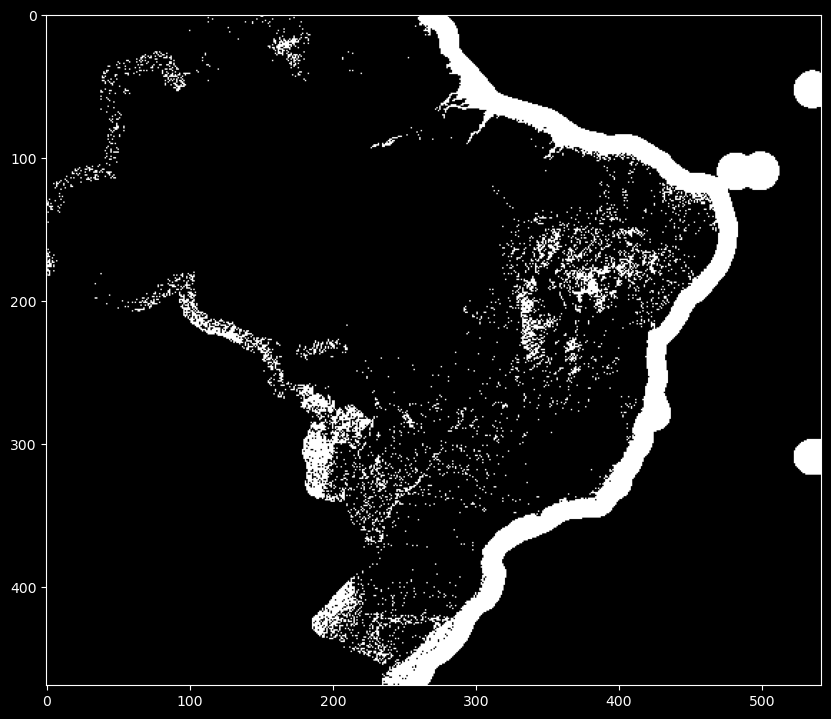

In [46]:
plot_raster(M)

In [175]:
# down scale to 1km (due to memory constraints). Analysis will improve if we upscale to topology, but this is a good start
# power_density = scale_and_crop_raster(power_density, power_density_transform, power_density_meta['crs'], population_transform, population.shape, population_meta['crs'])
# wind_speed = scale_and_crop_raster(wind_speed, wind_speed_transform, wind_speed_meta['crs'], population_transform, population.shape, population_meta['crs'])
# roughness = scale_and_crop_raster(roughness, roughness_transform, roughness_meta['crs'], population_transform, population.shape, population_meta['crs'])
# slope = scale_and_crop_raster(slope, slope_transform, slope_meta['crs'], population_transform, population.shape, population_meta['crs'])

### infrastructure | vector

## exploration

<Axes: >

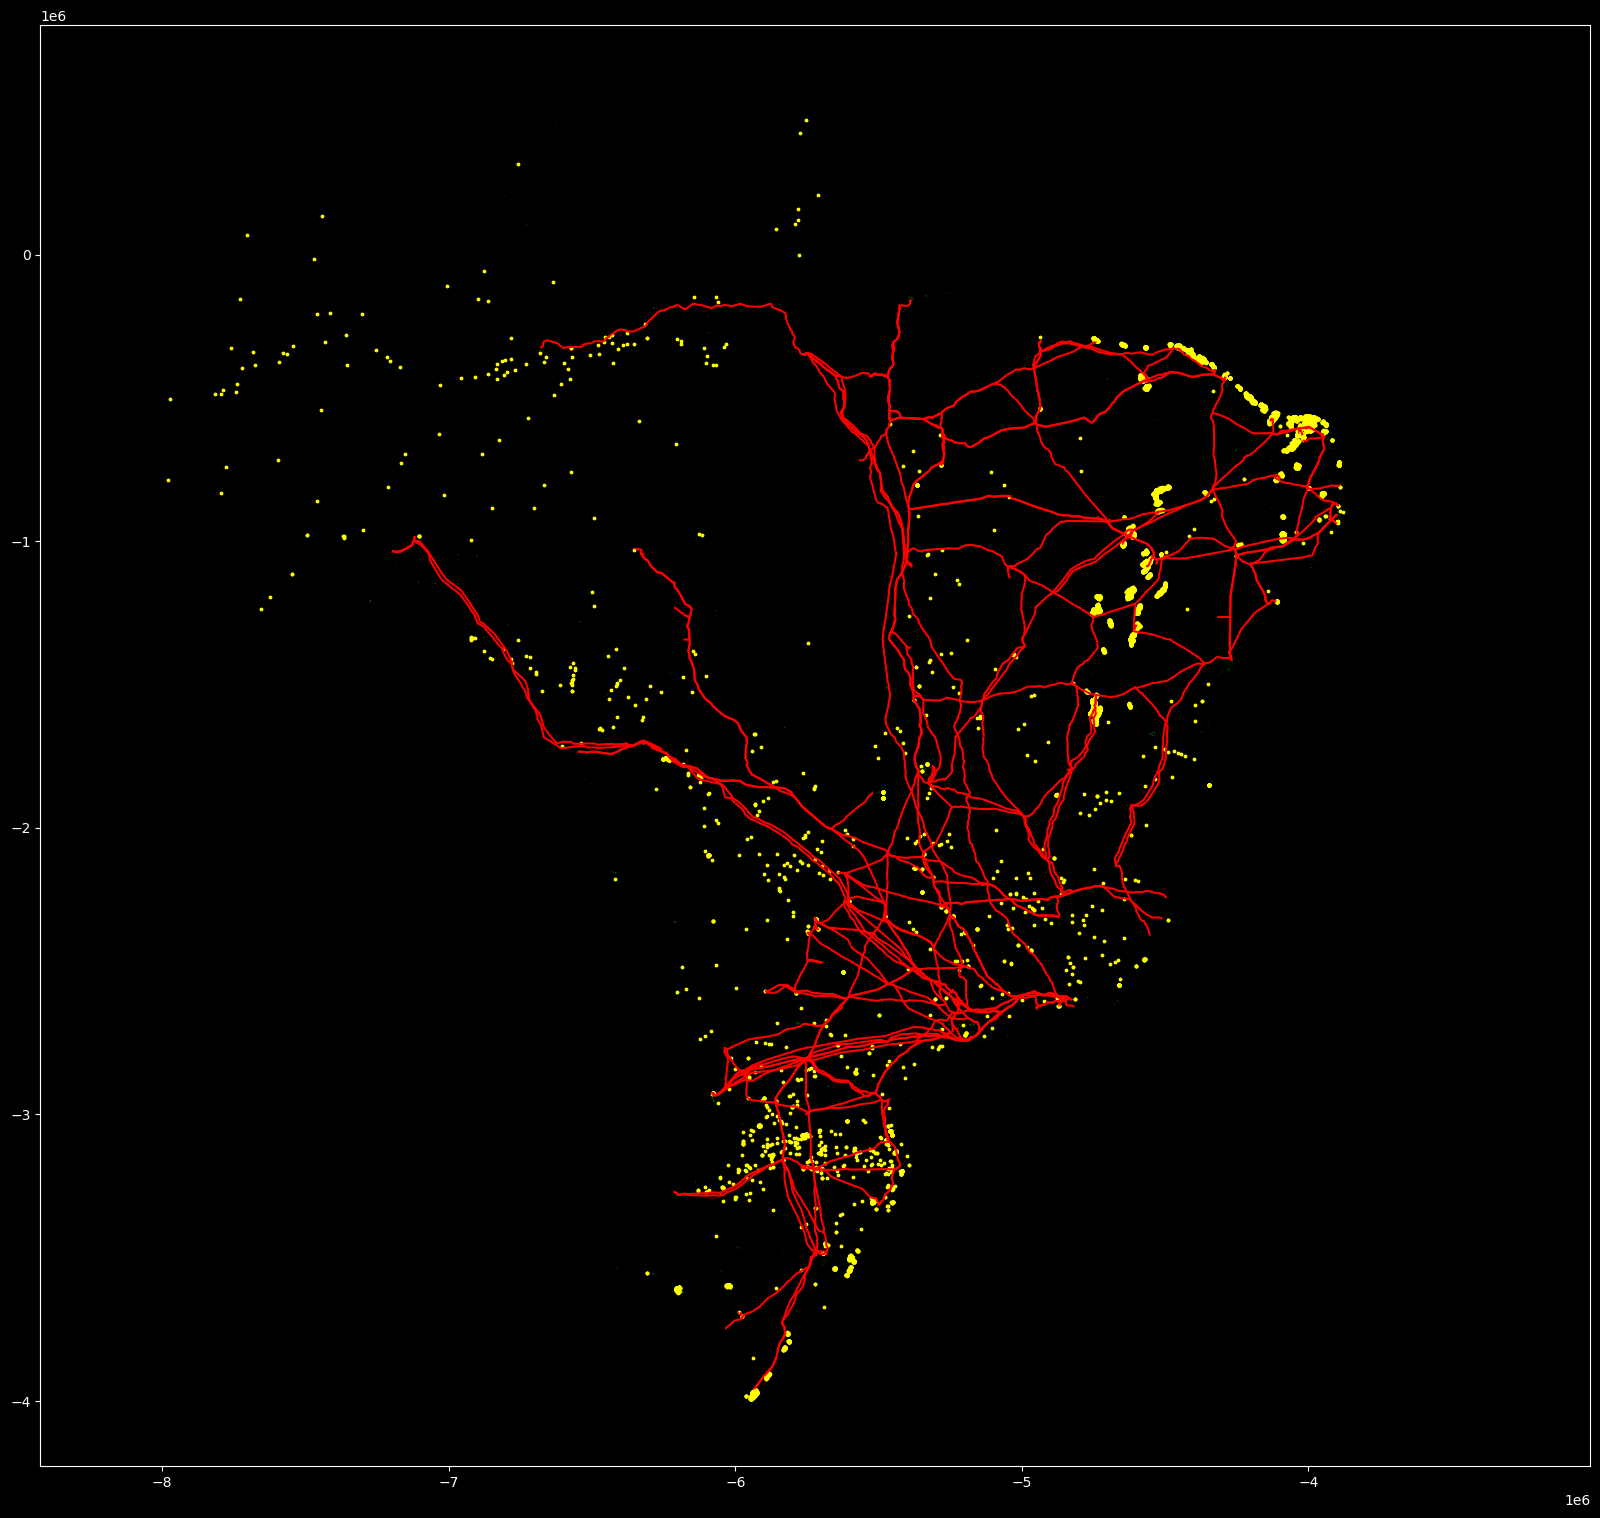

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
landuse.plot(ax=ax, color='green', markersize=3)
power.plot(ax=ax, color='red', markersize=3)
powergeneration.plot(ax=ax, color='yellow', markersize=3)

## constraints

In [ ]:
# this metereology mask is rater based and has the crs of the raster
metereology_mask = (wind_speed > 8) & (wind_speed < 12) & (power_density > 200)

In [ ]:

population_mask = population_density['Z'] < 1

In [21]:
wind_speed

array([[-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       ...,
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.]], dtype=float32)

## optimization